In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('../')
from GPHetero import hetero_kernels, hetero_likelihoods, hetero_gpmc

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

In [2]:
def ell_function(x):
    x = 6 * x
    return (4 * (1. - np.sin(x[0] + 8 * np.exp(x[0] - 7.))) \
        - 10.) / 5. + 6

In [3]:
np.random.seed(50)

num_quad_points = 100

X_train = np.linspace(0, 1, num_quad_points)[:, None] # The 1D input space for generating a sample function
X_train_norm = (X_train - 0.5)/0.5
mu = np.zeros(num_quad_points)

ell_f = np.array([ell_function(x) for x in X_train])[:, None]

Cov = hetero_kernels.NonStationaryLengthscaleRBF()
Cov.signal_variance = 10.
Cov.signal_variance.fixed = True

K = Cov.compute_K(X_train, ell_f, X_train, ell_f)

Y_train = np.random.multivariate_normal(mu, K, 1).T

/Users/nimishawalgaonkar/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:17: RuntimeWarning: covariance is not positive-semidefinite.


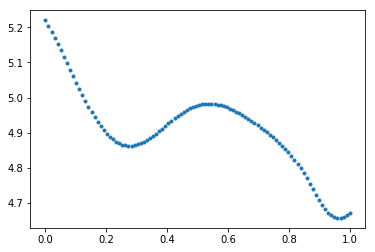

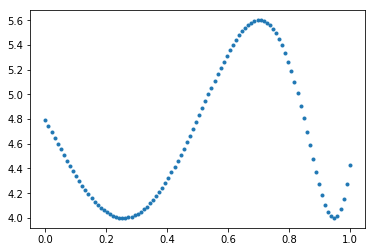

In [4]:
plt.figure()
plt.plot(X_train,Y_train, '.')
plt.figure()
plt.plot(X_train, ell_f, '.')

In [5]:
#build the model
k1 = hetero_kernels.RBF(1)
k2 = hetero_kernels.RBF(1)
nonstat = hetero_kernels.NonStationaryLengthscaleRBF()
m = hetero_gpmc.GPMCAdaptLAdaptN(X_train_norm, Y_train, k1, k2, nonstat)

In [6]:
m.kern1.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
m.kern1.variance = 1.
m.kern1.variance.fixed = True
#m.kern1.variance.prior = gpflow.priors.Gamma(1., 1.)

m.kern2.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
m.kern2.variance = 0.001
m.kern2.variance.fixed = True

m.nonstat.signal_variance = .1
m.nonstat.signal_variance.fixed = True

In [7]:
m.optimize(maxiter=5000)

      fun: array([ 481.58104678])
 hess_inv: <303x303 LbfgsInvHessProduct with dtype=float64>
      jac: array([  2.75392671e-04,   4.19012965e-04,   1.18707041e-04,
         8.22721702e-05,   1.19287006e-04,   2.07813742e-04,
         2.70641933e-04,   2.56383644e-04,   2.07767777e-04,
         1.70472442e-04,   1.51525653e-04,   1.39933053e-04,
         1.25370210e-04,   1.03552415e-04,   7.56609458e-05,
         4.62887012e-05,   2.10206848e-05,   4.26373297e-06,
        -1.85626456e-06,   2.48503164e-06,   1.52494361e-05,
         3.31962608e-05,   5.28026344e-05,   7.11650179e-05,
         8.64661519e-05,   9.79274772e-05,   1.05487045e-04,
         1.09463731e-04,   1.10329153e-04,   1.08590576e-04,
         1.04744641e-04,   9.92590625e-05,   9.25545821e-05,
         8.49788458e-05,   7.67888564e-05,   6.81633354e-05,
         5.92530279e-05,   5.02477731e-05,   4.14228942e-05,
         3.31348875e-05,   2.57637812e-05,   1.96297053e-05,
         1.49212144e-05,   1.16632670e-05

In [8]:
samples = m.sample(2000, verbose=True, epsilon=0.01, thin = 2, burn = 1000, Lmax = 40)

burn-in sampling started
Iteration:  100 	 Acc Rate:  96.0 %
Iteration:  200 	 Acc Rate:  100.0 %
Iteration:  300 	 Acc Rate:  100.0 %
Iteration:  400 	 Acc Rate:  100.0 %
Iteration:  500 	 Acc Rate:  100.0 %
Iteration:  600 	 Acc Rate:  100.0 %
Iteration:  700 	 Acc Rate:  100.0 %
Iteration:  800 	 Acc Rate:  100.0 %
Iteration:  900 	 Acc Rate:  100.0 %
Iteration:  1000 	 Acc Rate:  100.0 %
burn-in sampling ended
Iteration:  100 	 Acc Rate:  98.0 %
Iteration:  200 	 Acc Rate:  100.0 %
Iteration:  300 	 Acc Rate:  100.0 %
Iteration:  400 	 Acc Rate:  100.0 %
Iteration:  500 	 Acc Rate:  100.0 %
Iteration:  600 	 Acc Rate:  100.0 %
Iteration:  700 	 Acc Rate:  100.0 %
Iteration:  800 	 Acc Rate:  100.0 %
Iteration:  900 	 Acc Rate:  100.0 %
Iteration:  1000 	 Acc Rate:  100.0 %
Iteration:  1100 	 Acc Rate:  100.0 %
Iteration:  1200 	 Acc Rate:  100.0 %
Iteration:  1300 	 Acc Rate:  100.0 %
Iteration:  1400 	 Acc Rate:  99.0 %
Iteration:  1500 	 Acc Rate:  100.0 %
Iteration:  1600 	 Acc 

In [9]:
m

Name,values,prior,constraint
adapt_ll_noise_gps.V1,[[ 1.60928646e+00] [ 4.58976417e-01] [ 1.11288448e-01] [ 1.74460129e-01] [ 2.51338699e-01] [ 2.93959283e-01] [ 2.84272127e-01] [ 2.43776524e-01] [ 2.00101181e-01] [ 1.66093212e-01] [ 1.43845010e-01] [ 1.31724762e-01] [ 1.27515145e-01] [ 1.29221947e-01] [ 1.35091648e-01] [ 1.43461643e-01] [ 1.52657292e-01] [ 1.61016845e-01] [ 1.67058400e-01] [ 1.69727237e-01] [ 1.68597418e-01] [ 1.63908756e-01] [ 1.56412723e-01] [ 1.47108367e-01] [ 1.36988014e-01] [ 1.26871818e-01] [ 1.17344169e-01] [ 1.08762717e-01] [ 1.01302193e-01] [ 9.50053576e-02] [ 8.98269618e-02] [ 8.56663775e-02] [ 8.23896388e-02] [ 7.98435790e-02] [ 7.78650071e-02] [ 7.62874419e-02] [ 7.49472358e-02] [ 7.36901317e-02] [ 7.23784832e-02] [ 7.08986168e-02] [ 6.91672450e-02] [ 6.71356328e-02] [ 6.47904476e-02] [ 6.21508730e-02] [ 5.92623992e-02] [ 5.61884380e-02] [ 5.30012727e-02] [ 4.97737756e-02] [ 4.65728967e-02] [ 4.34553693e-02] [ 4.04655707e-02] [ 3.76351449e-02] [ 3.49838609e-02] [ 3.25211912e-02] [ 3.02481965e-02] [ 2.81594289e-02] [ 2.62446866e-02] [ 2.44905385e-02] [ 2.28816049e-02] [ 2.14016065e-02] [ 2.00342125e-02] [ 1.87637203e-02] [ 1.75755914e-02] [ 1.64568607e-02] [ 1.53964295e-02] [ 1.43852420e-02] [ 1.34163473e-02] [ 1.24848463e-02] [ 1.15877309e-02] [ 1.07236300e-02] [ 9.89248559e-03] [ 9.09518936e-03] [ 8.33321212e-03] [ 7.60825788e-03] [ 6.92196769e-03] [ 6.27569013e-03] [ 5.67032456e-03] [ 5.10623623e-03] [ 4.58323341e-03] [ 4.10059403e-03] [ 3.65712778e-03] [ 3.25125936e-03] [ 2.88112230e-03] [ 2.54465232e-03] [ 2.23967634e-03] [ 1.96399067e-03] [ 1.71542522e-03] [ 1.49189473e-03] [ 1.29143118e-03] [ 1.11219804e-03] [ 9.52490177e-04] [ 8.10716027e-04] [ 6.85376846e-04] [ 5.75045316e-04] [ 4.78360655e-04] [ 3.94027344e-04] [ 3.20821883e-04] [ 2.57581800e-04] [ 2.03170799e-04] [ 1.56442581e-04]],"N([ 0.],[ 1.])",(none)
adapt_ll_noise_gps.V2,[[ -1.75925969e+00] [ -4.28895974e-01] [ -5.76296786e-01] [ -5.75123397e-01] [ -4.92215818e-01] [ -3.99491326e-01] [ -3.24783146e-01] [ -2.71095978e-01] [ -2.34528574e-01] [ -2.10673532e-01] [ -1.96022107e-01] [ -1.87974585e-01] [ -1.84592902e-01] [ -1.84376936e-01] [ -1.86112110e-01] [ -1.88782220e-01] [ -1.91532225e-01] [ -1.93664848e-01] [ -1.94654518e-01] [ -1.94162657e-01] [ -1.92041290e-01] [ -1.88317928e-01] [ -1.83162034e-01] [ -1.76839560e-01] [ -1.69664813e-01] [ -1.61958056e-01] [ -1.54014019e-01] [ -1.46082742e-01] [ -1.38361374e-01] [ -1.30994092e-01] [ -1.24077066e-01] [ -1.17665895e-01] [ -1.11783674e-01] [ -1.06428603e-01] [ -1.01580569e-01] [ -9.72065630e-02] [ -9.32649646e-02] [ -8.97088690e-02] [ -8.64886412e-02] [ -8.35538982e-02] [ -8.08550611e-02] [ -7.83446156e-02] [ -7.59781476e-02] [ -7.37152189e-02] [ -7.15200846e-02] [ -6.93622569e-02] [ -6.72168940e-02] [ -6.50649969e-02] [ -6.28933862e-02] [ -6.06944584e-02] [ -5.84657415e-02] [ -5.62092544e-02] [ -5.39307412e-02] [ -5.16388128e-02] [ -4.93440668e-02] [ -4.70582381e-02] [ -4.47934266e-02] [ -4.25614334e-02] [ -4.03732380e-02] [ -3.82386097e-02] [ -3.61658564e-02] [ -3.41616924e-02] [ -3.22312171e-02] [ -3.03779614e-02] [ -2.86040109e-02] [ -2.69101530e-02] [ -2.52960571e-02] [ -2.37604635e-02] [ -2.23013662e-02] [ -2.09161901e-02] [ -1.96019535e-02] [ -1.83554133e-02] [ -1.71731919e-02] [ -1.60518840e-02] [ -1.49881452e-02] [ -1.39787595e-02] [ -1.30206957e-02] [ -1.21111403e-02] [ -1.12475197e-02] [ -1.04275086e-02] [ -9.64902453e-03] [ -8.91021386e-03] [ -8.20942524e-03] [ -7.54518305e-03] [ -6.91615154e-03] [ -6.32110337e-03] [ -5.75889683e-03] [ -5.22845521e-03] [ -4.72876322e-03] [ -4.25887137e-03] [ -3.81789567e-03] [ -3.40501938e-03] [ -3.01947524e-03] [ -2.66052082e-03] [ -2.32739824e-03] [ -2.01930863e-03] [ -1.73539525e-03] [ -1.47476448e-03] [ -1.23654977e-03] [ -1.01999366e-03]],"N([ 0.],[ 1.])",(none)
adapt_ll_noise_gps.V3,[[ 1.41210908e+01] [ 1.96571766e+00] [ 1.14868236e+00] [ 6.24354716e-01] [ 3.90218670e-01] [ 2.76544666e-01] [ 2.17837873e-01] [ 1.87637212e-01] [ 1.7365

In [10]:
sample_df = m.get_samples_df(samples)

In [11]:
mean_l_mat = np.zeros(shape = (samples.shape[0], X_train_norm.shape[0]))
var_l_mat = np.zeros(shape = (samples.shape[0], X_train_norm.shape[0]))

In [12]:
for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    mean1, v1 = m.predict_l(X_train_norm)
    var1 = v1[:,:]
    mean_l_mat[i,:] = mean1[:,0]
    var_l_mat[i,:] = np.diag(var1)

std_l_mat = np.sqrt(var_l_mat)

In [13]:
LowerlogL = mean_l_mat - 2*std_l_mat
UpperlogL = mean_l_mat + 2*std_l_mat

In [14]:
MeanL = np.exp(mean_l_mat)
LowerL = np.exp(LowerlogL)
UpperL = np.exp(UpperlogL)

In [15]:
def visualize(Xgrid, M, L, U):
    """
    Visualize 1D utility funciton values
    Xgrid : grid states
    Mgrid : mean of GP at those finite grid points
    Vargrid : variance of GP at those finite grid points
    """
    
    line, = plt.plot(Xgrid, M, lw = 2, color = 'b', label = 'utility', alpha = 0.5)
    plt.fill_between(Xgrid[:,0], L, U,
                     color = 'b', alpha = 0.25)
    #plt.fill_between(Xgrid[:,0], lower1, upper1,
    #                 color = 'g', alpha = 0.25)
    plt.xlabel('x')
    plt.ylabel('y')
    return

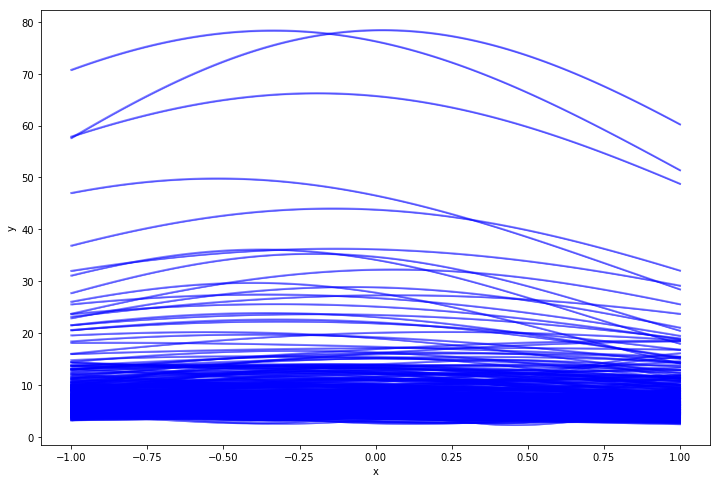

In [16]:
mini = 505
maxi = 910
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize(X_train_norm, MeanL[i,:], LowerL[i,:], UpperL[i,:])  

In [17]:
mean_n_mat = np.zeros(shape = (samples.shape[0], X_train_norm.shape[0]))
var_n_mat = np.zeros(shape = (samples.shape[0], X_train_norm.shape[0]))

In [18]:
for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    mean1, v1 = m.predict_n(X_train_norm)
    var1 = v1[:,:]
    mean_n_mat[i,:] = mean1[:,0]
    var_n_mat[i,:] = np.diag(var1)

std_n_mat = np.sqrt(var_n_mat)

In [19]:
LowerlogN = mean_n_mat - 2*std_n_mat
UpperlogN = mean_n_mat + 2*std_n_mat

In [20]:
MeanN = np.exp(mean_n_mat)
LowerN = np.exp(LowerlogN)
UpperN = np.exp(UpperlogN)

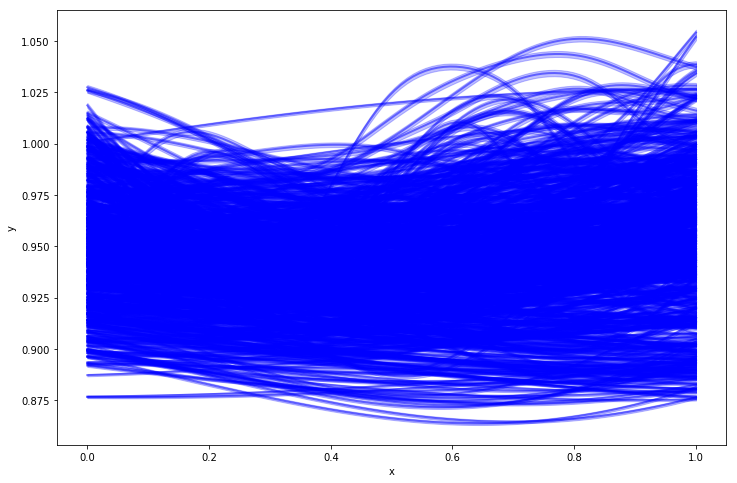

In [21]:
mini = 500
maxi = 1110
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize(X_train, MeanN[i,:], LowerN[i,:], UpperN[i,:])  

In [22]:
sig_samples = m.signal_variance.get_samples_df(samples)
signal_var = np.array([])
for s in sig_samples:
    signal_var = np.append(signal_var, s)

In [23]:
mean_f_mat = np.zeros(shape = (samples.shape[0], X_train_norm.shape[0]))
var_f_mat = np.zeros(shape = (samples.shape[0], X_train_norm.shape[0]))

for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    mean1, v1 = m.predict_f(X_train_norm)
    var1 = v1[:,:]
    mean_f_mat[i,:] = mean1[:,0]
    var_f_mat[i,:] = np.diag(var1)    

In [24]:
std_f_mat = np.sqrt(var_f_mat)

In [25]:
Lowerf = mean_f_mat - 2*std_f_mat
Upperf = mean_f_mat + 2*std_f_mat

In [26]:
def visualize_all(Xgrid, M1, L1, U1, U2, signal_var):
    """
    Visualize
    """  
    L2 = L1 - U2
    U2 = U1 + U2
    
    plt.plot(X_train, Y_train, '.')
    line, = plt.plot(Xgrid, M1, lw = 2, color = 'b', label = 'utility', alpha = 0.5)
    plt.fill_between(Xgrid[:,0], L1, U1,
                     color = 'b', alpha = 0.25)
    plt.fill_between(Xgrid[:,0], L2, U2,
                     color = 'g', alpha = 0.25)
    plt.xlabel('x')
    plt.ylabel('y')
    return

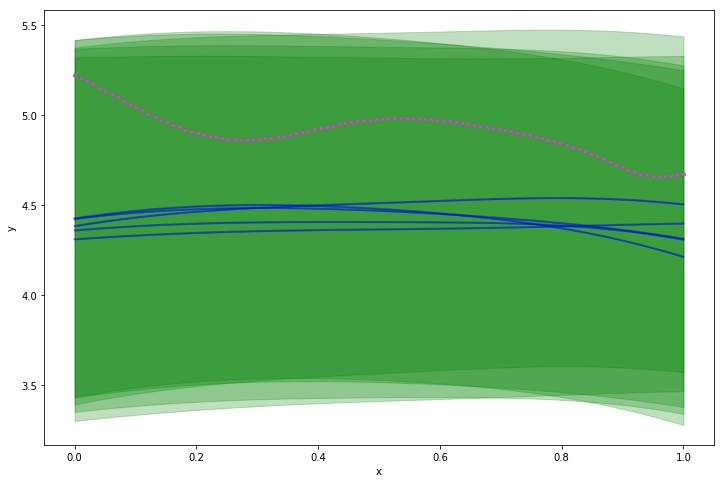

In [27]:
mini = 1900
maxi = 1905
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize_all(X_train, mean_f_mat[i,:],
              Lowerf[i,:], Upperf[i,:],
              UpperN[i,:], signal_var[i])